In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#start_date=datetime.datetime(2020,1,1)
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [5]:
days=(today-start_date).days
days

1902

In [6]:
remaining=days%500
numbers_of_table=days//500

In [31]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(['TRXBTC'],temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(['TRXBTC'],temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]

In [32]:
prices.index=pd.to_datetime(prices.index)

In [33]:
prices2=prices.copy()
prices2=prices2.loc['2025':]

In [34]:
ret = prices2.pct_change()['TRXBTC']
up = []
down = []
for i in range(len(ret)):
    if ret[i] < 0:
        up.append(0)
        down.append(ret[i])
    else:
        up.append(ret[i])
        down.append(0)

C:\Users\niroo\AppData\Local\Temp\ipykernel_24444\3943043918.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ret[i] < 0:
C:\Users\niroo\AppData\Local\Temp\ipykernel_24444\3943043918.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up.append(ret[i])
C:\Users\niroo\AppData\Local\Temp\ipykernel_24444\3943043918.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down.append(ret[i])


In [13]:
up_series = pd.Series(up)
down_series = pd.Series(down).abs()
up_ewm = up_series.ewm(com = 14 - 1, adjust = False).mean()
down_ewm = down_series.ewm(com = 14 - 1, adjust = False).mean()
rs = up_ewm/down_ewm
rsi = 100 - (100 / (1 + rs))
rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(prices2.index)
rsi_df = rsi_df.dropna()

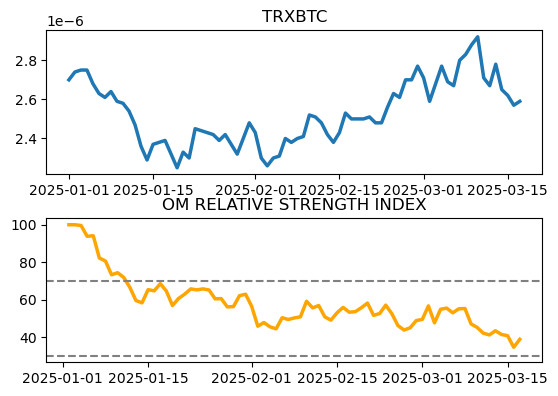

In [39]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(prices2['TRXBTC'], linewidth = 2.5)
ax1.set_title('TRXBTC')
ax2.plot(rsi_df['rsi'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('OM RELATIVE STRENGTH INDEX')
plt.show()

In [45]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 50 and rsi[i] < 50:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 65 and rsi[i] > 65:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

buy_price, sell_price, rsi_signal = implement_rsi_strategy(prices2['TRXBTC'], rsi_df['rsi'])

C:\Users\niroo\AppData\Local\Temp\ipykernel_24444\346266388.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rsi[i-1] > 50 and rsi[i] < 50:
C:\Users\niroo\AppData\Local\Temp\ipykernel_24444\346266388.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif rsi[i-1] < 65 and rsi[i] > 65:
C:\Users\niroo\AppData\Local\Temp\ipykernel_24444\346266388.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_price.append(prices[i])

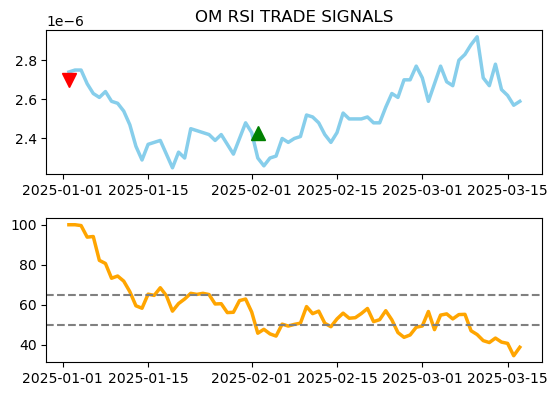

In [47]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(prices2['TRXBTC'][1:], linewidth = 2.5, color = 'skyblue', label = 'OM')
ax1.plot(prices2.index[1:], buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(prices2.index[1:], sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('OM RSI TRADE SIGNALS')
ax2.plot(rsi_df['rsi'], color = 'orange', linewidth = 2.5)
ax2.axhline(50, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(65, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()